**Büşra** **GÖKMEN**

In [ ]:
import pandas as pd
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# read data and create dataframe
df = pd.read_csv('/content/drive/My Drive/term-deposit-marketing-2020.csv')
term_deposits = df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [ ]:
dep = term_deposits['y']
term_deposits.drop(labels=['y'], axis=1,inplace=True)
term_deposits.insert(0, 'y', dep)
term_deposits.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,no,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,no,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,no,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1
3,no,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1
4,no,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1


In [ ]:
# Here we split the data into training and test sets and implement a stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]

In [ ]:
# test and train data
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test # Make a copy of the stratified testing set.
train_data['y'].value_counts()

no     29702
yes     2298
Name: y, dtype: int64

In [134]:
test_data['y'].value_counts()

no     7402
yes     598
Name: y, dtype: int64

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np

# function for encoding of categorical data
class CategoricalEncoder(BaseEstimator, TransformerMixin):
   
    

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines for transforming data
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month"
                                     ])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train
X_test = preprocess_pipeline.fit_transform(test_data)
X_test

array([[-1.19230359, -0.41294643,  0.95536651, ...,  0.        ,
         0.        ,  0.        ],
       [-1.08824271,  2.34166124,  0.2321747 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.88012094, -0.37841983,  0.35270667, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.99297497,  0.57123271,  1.55802635, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36860967, -0.32098944,  0.11164274, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.26454878, -0.36440408, -0.85261301, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
y_train = train_data['y']
y_test = test_data['y']
y_train.shape

(32000,)

In [ ]:
from sklearn.preprocessing import LabelEncoder
#encoding label

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)


In [ ]:
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 # models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=20),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [ ]:
# Use 5-fold Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=5)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=5)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=5)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=5)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

In [129]:
# All our models performances
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
4,Grad B CLF,0.939250
1,SVC,0.935844
5,Rand FC,0.935812
0,Logistic Reg.,0.935469
6,Neural Classifier,0.933875
7,Naives Bayes,0.933875
2,KNN,0.932281
3,Dec Tree,0.914687


In [ ]:
# 5-Fold Cross validate our models with unseen data
from sklearn.model_selection import cross_val_predict

y_test_pred_1 = cross_val_predict(grad_clf, X_test, y_test, cv=5)
y_test_pred_2 = cross_val_predict(log_reg, X_test, y_test, cv=5)
y_test_pred_3 = cross_val_predict(svc_clf, X_test, y_test, cv=5)
y_test_pred_4 = cross_val_predict(knn_clf, X_test, y_test, cv=5)
y_test_pred_5 = cross_val_predict(tree_clf, X_test, y_test, cv=5)
y_test_pred_6 = cross_val_predict(rand_clf, X_test, y_test, cv=5)
y_test_pred_7 = cross_val_predict(neural_clf, X_test, y_test, cv=5)
y_test_pred_8 = cross_val_predict(nav_clf, X_test, y_test, cv=5)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

NameError: ignored

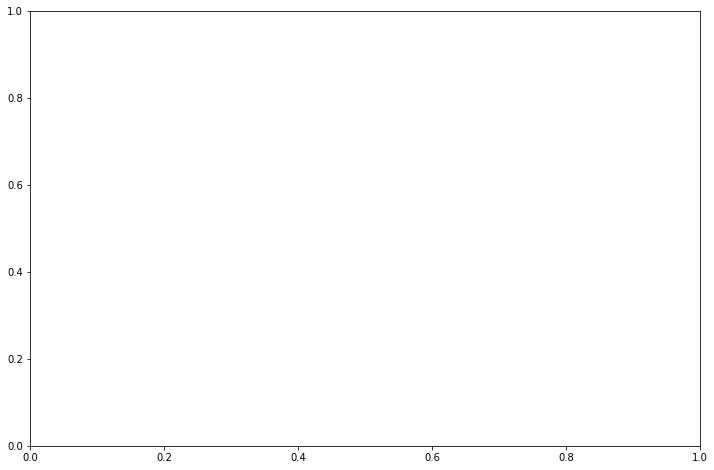

In [130]:
# confusion matrix for gradient boosting classifier model
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_1)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused Term Deposits', 'Accepted Term Deposits'], fontsize=16, rotation=360)
plt.show()

In [131]:
# Let's find the scores for precision,recall,f1 and accuracy.
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("Gradient Boosting Classifier -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_1))
print('Precision Score: ', precision_score(y_test, y_test_pred_1))
print('Recall Score: ', recall_score(y_test, y_test_pred_1))
print('F1 Score: ', f1_score(y_test, y_test_pred_1))
print("Logistic Regression -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_2))
print('Precision Score: ', precision_score(y_test, y_test_pred_2))
print('Recall Score: ', recall_score(y_test, y_test_pred_2))
print('F1 Score: ', f1_score(y_test, y_test_pred_2))
print("SVM -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_3))
print('Precision Score: ', precision_score(y_test, y_test_pred_3))
print('Recall Score: ', recall_score(y_test, y_test_pred_3))
print('F1 Score: ', f1_score(y_test, y_test_pred_3))
print("KNeighbors Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_4))
print('Precision Score: ', precision_score(y_test, y_test_pred_4))
print('Recall Score: ', recall_score(y_test, y_test_pred_4))
print('F1 Score: ', f1_score(y_test, y_test_pred_4))
print("Decision Trees Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_5))
print('Precision Score: ', precision_score(y_test, y_test_pred_5))
print('Recall Score: ', recall_score(y_test, y_test_pred_5))
print('F1 Score: ', f1_score(y_test, y_test_pred_5))
print("Random Forest Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_6))
print('Precision Score: ', precision_score(y_test, y_test_pred_6))
print('Recall Score: ', recall_score(y_test, y_test_pred_6))
print('F1 Score: ', f1_score(y_test, y_test_pred_6))
print("MLP Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_7))
print('Precision Score: ', precision_score(y_test, y_test_pred_7))
print('Recall Score: ', recall_score(y_test, y_test_pred_7))
print('F1 Score: ', f1_score(y_test, y_test_pred_7))
print("GaussianNB-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_8))
print('Precision Score: ', precision_score(y_test, y_test_pred_8))
print('Recall Score: ', recall_score(y_test, y_test_pred_8))
print('F1 Score: ', f1_score(y_test, y_test_pred_8))

Gradient Boosting Classifier -------------------------------------------------
Accuracy Score:  0.93275
Precision Score:  0.5887573964497042
Recall Score:  0.33277591973244147
F1 Score:  0.4252136752136752
Logistic Regression -------------------------------------------------
Accuracy Score:  0.932
Precision Score:  0.6007462686567164
Recall Score:  0.2692307692307692
F1 Score:  0.37182448036951504
SVM -------------------------------------------------
Accuracy Score:  0.93025
Precision Score:  0.6123595505617978
Recall Score:  0.18227424749163879
F1 Score:  0.2809278350515464
KNeighbors Classifier-------------------------------------------------
Accuracy Score:  0.92925
Precision Score:  0.5625
Recall Score:  0.2408026755852843
F1 Score:  0.33723653395784536
Decision Trees Classifier-------------------------------------------------
Accuracy Score:  0.907625
Precision Score:  0.3886255924170616
Recall Score:  0.411371237458194
F1 Score:  0.3996750609260764
Random Forest Classifier-------



*  Accuracy scores and cross validation mean scores are high rate but recall and precision and f1-score is low rate. This is because data is imbalanced(no:37104,yes:2796) We need to take different approaches to balance data. Since Gradient Boosting Classifier and Decision Trees Classifier give highest accuracy and f1 scores, we chose this models and we will continue...


In [ ]:
# install necessary packages
!pip install imbalanced-learn
!pip install combo

In [136]:
dep = term_deposits['y']
X=term_deposits
y=dep




*First Approach*


```
We increase data that is labeled with yes(oversampling) and decrease data that is labeled with no(undersampling).
```



In [137]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

#oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=0.5)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
from collections import Counter
# summarize class distribution
print(Counter(y_over))

Counter({'no': 37104, 'yes': 18552})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [138]:
#undersampling
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.7)
# fit and apply the transform
X_over, y_over= under.fit_resample(X_over, y_over)
# summarize class distribution
print(Counter(y_over))

Counter({'no': 26502, 'yes': 18552})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [139]:
print(X_over)

[['no' 33 'admin' ... 'may' 565 1]
 ['no' 49 'management' ... 'jul' 47 5]
 ['no' 31 'management' ... 'nov' 74 1]
 ...
 ['yes' 54 'unemployed' ... 'apr' 241 1]
 ['yes' 37 'housemaid' ... 'may' 899 3]
 ['yes' 30 'admin' ... 'nov' 898 1]]


In [140]:
 
df = pd.DataFrame(X_over, columns=['y','age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign'])

In [141]:
df.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,no,33,admin,single,secondary,no,1613,yes,no,unknown,14,may,565,1
1,no,49,management,married,secondary,no,1601,no,no,cellular,29,jul,47,5
2,no,31,management,single,tertiary,no,44128,no,no,cellular,21,nov,74,1
3,no,38,management,single,tertiary,no,427,yes,no,cellular,6,may,17,3
4,no,42,management,divorced,secondary,no,-272,no,no,cellular,8,jul,186,1


In [142]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(df, df["loan"]):
    stratified_train = df.loc[train_set]
    stratified_test = df.loc[test_set]

In [143]:
# seperate train and test data
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test # Make a copy of the stratified testing set.
train_data.shape

#train_data['y'].value_counts()

(36043, 14)

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines for transforming data
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month"
                                     ])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [145]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train
X_test = preprocess_pipeline.fit_transform(test_data)
X_test

array([[-0.62005053, -0.31966965,  0.01143754, ...,  1.        ,
         0.        ,  0.        ],
       [-0.62005053, -0.42331   ,  0.72468109, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81591659,  0.43786652,  0.36805932, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.55514585, -0.67938358,  1.31905071, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03245234, -0.76201093, -1.53392348, ...,  0.        ,
         0.        ,  0.        ],
       [-0.5221175 ,  1.04475021,  0.01143754, ...,  0.        ,
         0.        ,  0.        ]])

In [147]:
y_train = train_data['y']
y_test = test_data['y']
y_train.shape

(36043,)

In [148]:
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)


In [150]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import cross_val_score

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)
tree_mean = tree_scores.mean()
print('5-Fold Cross Validation Avarage Score of Decision Tree: ',tree_mean)

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=5)
grad_mean = grad_scores.mean()
print('5-Fold Cross Validation Avarage Score of Gradient Boosting Classifier: ',grad_mean)

5-Fold Cross Validation Avarage Score of Decision Tree:  0.9561080773832314
5-Fold Cross Validation Avarage Score of Gradient Boosting Classifier:  0.8793109650364593


In [152]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
y_test_pred_1 = cross_val_predict(grad_clf, X_test, y_test, cv=5)


print('Precision Score: ', precision_score(y_test, y_test_pred_1))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_test, y_test_pred_1))
print('F1-Score: ', f1_score(y_test, y_test_pred_1))
print("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_test, y_test_pred_1))

Precision Score:  0.8451292765735179
Recall Score:  0.8807838867719108
F1-Score:  0.8625882980141277
Gradient Boost Classifier accuracy is 0.89


In [153]:
y_test_pred_2 = cross_val_predict(tree_clf, X_test, y_test, cv=5)


print('Precision Score: ', precision_score(y_test, y_test_pred_2))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_test, y_test_pred_2))
print('F1-Score: ', f1_score(y_test, y_test_pred_2))
print("Decision Tree Classifier accuracy is %2.2f" % accuracy_score(y_test, y_test_pred_2))


Precision Score:  0.837014470677837
Recall Score:  0.8973870440936309
F1-Score:  0.8661500065677131
Decision Tree Classifier accuracy is 0.89



*Second Approach*


```
We will use ensemble learning by combining multiple classifying model. The combination of these models will increase the score.
```

In [ ]:
from combo.models.classifier_stacking import Stacking
from combo.utils.data import evaluate_print
# initialize a group of base classifiers - Ensemble Model
classifiers = [tree.DecisionTreeClassifier(), LogisticRegression(),
               KNeighborsClassifier(), RandomForestClassifier(),
               GradientBoostingClassifier()]

clf = Stacking(base_estimators=classifiers) # initialize a Stacking model
clf.fit(X_train, y_train) # fit the model

# predict on unseen data
y_test_labels=cross_val_predict(clf, X_test, y_test, cv=5)

In [165]:
#Model Evaluation
evaluate_print('Stacking | ', y_test, y_test_labels)

Stacking |  Accuracy:0.9142, ROC:0.9157, F1:0.8978


Final Results Report


*Cross Validation Avarage Result*
*  5-Fold Cross Validation Avarage Score of Decision Tree:0.95
* 5-Fold Cross Validation Avarage Score of Gradient Boosting Classifier:0.87



*Gradient Boost Classifier*
*   Precision Score:  0.8451292765735179
*  Recall Score:  0.8807838867719108
* F1-Score:  0.8625882980141277
* Gradient Boost Classifier accuracy is 0.89

*Decision Tree*
* Precision Score:  0.837014470677837
*  Recall Score:  0.8973870440936309
*  F1-Score:  0.8661500065677131
* Decision Tree Classifier accuracy is 0.89


*Combine of Multiple Classifier Models - Ensemble Model*

* Accuracy: 0.9142
* ROC: 0.9157
* F1: 0.8978




Which features affect the model more?


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = pd.read_csv("/content/drive/My Drive/term-deposit-marketing-2020.csv")
X = data.iloc[:, :-1].values   #independent columns
y = data.iloc[:, -1].values     #target column i.e price range
labelencoder_ = LabelEncoder()
for i in range(13):
  X[:,i] = labelencoder_.fit_transform(X[:,i])
y = labelencoder_.fit_transform(y)
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


# most effective feature is duration 

        Specs         Score
11   duration  2.045278e+06
5     balance  1.066761e+05
8     contact  3.921261e+02
12   campaign  3.607691e+02
10      month  1.308415e+02
0         age  7.180656e+01
6     housing  4.714734e+01
7        loan  3.184029e+01
1         job  3.022289e+01
3   education  2.590045e+01


In [ ]:
m = (df['y'] == 'yes')
df1=df[m]
n = (df['y'] == 'no')
df2=df[n]

In [ ]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
83,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
86,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
168,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes


In [ ]:
# Month
print(df1['month'].value_counts()[:3].index.tolist())
print(df2['month'].value_counts()[:3].index.tolist())
df3 = df2[df2['campaign']==1]
print(df3['month'].value_counts()[:3].index.tolist())

['may', 'apr', 'jul']
['may', 'jul', 'aug']
['may', 'jul', 'nov']


Pazarlama Etkinliği Ayları (month): Pazarlama faaliyetlerinin en yüksek olduğu ayın Mayıs ayı olduğunu gördük. Ancak, bu potansiyel müşterilerin vadeli mevduat tekliflerini(term deposit) reddetme eğiliminde olduğu aydı (En yüksek "no" oranı mayıs ayında). Bir sonraki pazarlama kampanyası için, kurumun pazarlama kampanyasını Mart, Eylül, Ekim ve Kasım aylarında odaklanması akıllıca olacaktır. (Kasım ayı, kampanya sayısının en düşük olduğu ay olduğu için dikkate alınmalıdır, kasım ayı kampanya sayısı arttırılabilir.)

In [ ]:
# Season
print(df1['month'].value_counts()[:12].index.tolist())

['may', 'apr', 'jul', 'jun', 'aug', 'feb', 'nov', 'mar', 'oct', 'jan', 'dec']


Mevsimsellik: Potansiyel müşteriler, ilkbahar ve yaz mevsimlerinde vadeli mevduata(term deposit) abone olmayı seçti. Bir sonraki pazarlama kampanyası, faaliyetlerini bu sezonlar boyunca odaklamalıdır.

In [ ]:
# Age
print(df1['age'].value_counts()[-30:].index.tolist())

[56, 24, 23, 61, 65, 22, 62, 21, 73, 71, 20, 74, 66, 63, 69, 64, 68, 70, 72, 76, 78, 85, 67, 75, 77, 83, 19, 79, 90, 95]


Yaş Kategorisi: Kurumun bir sonraki pazarlama kampanyası, 20'li yaşlarının başında ve 60'lı yaşların  üzerindeki potansiyel müşterileri hedeflemelidir. Bir sonraki kampanya için kurumun bu iki kategoriyi ele alması ve dolayısıyla daha fazla vadeli mevduat alma olasılığını artırması harika olacaktır.

In [ ]:
# Job
print(df1['job'].value_counts()[-3:].index.tolist())


['student', 'housemaid', 'unknown']


Meslek: Öğrenciler ve ev hanımları 'yes' diyen grup içinde azınlıklar. Bu yüzden bu azınlığı hedef alan ve alım olasılığını arttıran yeni kampanyalar yapılabilir.

In [ ]:
# Loan and Balance Relationship
n = (df['loan'] == 'yes')
df5=df[n]
print(df5['balance'].value_counts()[:10].index.tolist())
print(df5['balance'].value_counts()[-10:].index.tolist())


[0, 2, 1, 3, 4, 14, 5, 7, 80, 57]
[-318, 2371, 4420, 2387, -342, 4440, -350, -362, 2415, 4120]


Konut Kredileri ve Bakiyeleri: Düşük bakiye ve bakiyesiz kategorisindeki potansiyel müşterilerin, ortalama ve yüksek bakiye kategorisindeki kişilere göre konut kredisi alma olasılığı daha yüksek. Bir sonraki pazarlama kampanyası, vadeli mevduata yatkınlık olasılığını artırmak için ortalama ve yüksek bakiyeli kişilere odaklanmalıdır.

In [ ]:
# Duration
print(df1['duration'].mean())

682.9585635359116


Daha Uzun Süreli Hedef Bireyler (682'nin üzerinde): Süresi ortalamanın üzerinde olan hedef grubu hedefleyin, bu hedef grubun vadeli mevduat hesabı(term deposit) açma olasılığı yüksektir. Bu, bir sonraki pazarlama kampanyasının başarı oranının oldukça başarılı olmasını sağlayacaktır.

Görüşmeler Sırasında Anket Oluşturun: Görüşmenin süresi, potansiyel bir müşterinin vadeli mevduat açıp açmayacağı ile en olumlu ilişkili olan özellik olduğundan, görüşmeler sırasında potansiyel müşteriler için ilginç bir anket sağlayarak görüşme süresi artabilir. Elbette, bu bize potansiyel müşterinin vadeli depozitoya tabi olacağı konusunda garanti vermez. Bununla birlikte, potansiyel müşterinin katılım düzeyini artıracak bir strateji uygulayarak hiçbir şey kaybetmiyoruz, bu da vadeli mevduata bağlı kalma olasılığını artıracak ve bu nedenle kurumun uygulayacağı bir sonraki pazarlama kampanyası için etkinlik artışı olacaktır.



Tüm bu stratejileri birleştirerek ve bir sonraki kampanyanın hitap etmesi gereken pazar kitlesini basitleştirerek, bankanın bir sonraki pazarlama kampanyasının mevcut kampanyadan daha etkili olması muhtemeldir.